# Simulation with AVISO fields - Bigger Domain - NRT



### Weekly backward simulations within the Oleander domain (Gulf Stream). Running days= 7. Near-real-time simulations.


In [1]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
from datetime import timedelta as delta

from matplotlib              import dates as mdates
from datetime                import datetime 
import pickle

## Save the outputs in this directory

In [2]:
dirsave    = '/Users/bbarcelo/HOME_SCIENCE/Data/2019_SSS_Ladvection/sim_weekly_all_Bigger_Domain/sim_outputs/' #save outputs directory

## Altimetry data directory

In [3]:
dir_netcdf    = '/Users/bbarcelo/HOME_SCIENCE/Data/2019_SSS/SLA_GS_big_region/' 
# Data from 2019-05-14 to 2020-01-15
file_currents = 'dataset-duacs-nrt-global-merged-allsat-phy-l4_1583920119159.nc'
print(file_currents)

   
# current field file starts at this date, check for each new file the first date in altimetry_check_first_day.py
date_ori     = mdates.date2num(datetime(2019, 5, 14, 0, 0, 0))  
date_alt_fin = mdates.date2num(datetime(2020, 1, 15, 0, 0, 0)) #end day of delayed-time fiel  

dataset-duacs-nrt-global-merged-allsat-phy-l4_1583920119159.nc


## Running times to test

In [4]:
rund = [7,1] # run times for each simulation

## Define the particles release grid

In [5]:
# DOMAIN FOR weekly simulations BIGGER DOMAIN
lonmin, lonmax = -82, -63 #-74, -66 #-74, -68
latmin, latmax =  25, 46 #35, 40 #37, 40 

dx = 0.04

lons, lats = np.meshgrid(np.arange(360+lonmin, 360+lonmax, dx), np.arange(latmin, latmax, dx))

# we need to have lons, lats and times in a 1d vector (flatten)
lonf, latf = lons.flatten(), lats.flatten()

## Allow particles to leave the domain

Allow particles to leave the domain. We need to tell Parcels that particles that leave the domain need to be deleted. We do that using a `Recovery Kernel`, which will be invoked when a particle encounters an `ErrorOutOfBounds` error:

In [6]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

## File with the simulation dates

In [16]:
dir_dic    = '/Users/bbarcelo/HOME_SCIENCE/Data/2019_SSS_Ladvection/sim_weekly_all/'
file_dic = 'sim_weekly_relase_dates_corrected_gaps.pkl'

f = open(dir_dic + file_dic, 'rb')
dict_release_dates = pickle.load(f)
f.close() 

dates_release_all = dict_release_dates['date_release'] #- 0.5 #starting at 00:00 instead than at 12:00

# only dates in which we have delayed-time altimetry data 

ind_dt = np.where(dates_release_all>date_ori+6) # we need 7 days of currents before the release day

dates_release_pre = dates_release_all.astype(int)[ind_dt]
#dates_release_pre = list(dates_release_all.astype(int)[ind_dt])

print(dates_release_pre)

# now is not necessary to re-run all, only after and including 2019-6-11

date_to_start = mdates.date2num(datetime(2019, 6, 11, 0, 0, 0)) 

ind_rerun = np.where(dates_release_pre >= date_to_start) 

dates_release = list(dates_release_pre[ind_rerun])

print(dates_release)


[737200 737207 737214 737221 737273 737280 737287 737294 737301 737308
 737315 737322 737329 737336 737343 737350 737357 737364 737371 737378
 737385 737397 737404 737411 737418 737425 737432 737439 737446 737453
 737460 737467 737474 737481 737488 737495 737502]
[737221, 737273, 737280, 737287, 737294, 737301, 737308, 737315, 737322, 737329, 737336, 737343, 737350, 737357, 737364, 737371, 737378, 737385, 737397, 737404, 737411, 737418, 737425, 737432, 737439, 737446, 737453, 737460, 737467, 737474, 737481, 737488, 737495, 737502]


In [17]:
dates_release_all.shape


(252,)

In [18]:
len(dates_release)


34

In [19]:
date_to_start

737221.0

## Loop, do simulations for each date in the list

In [20]:
for date in dates_release:

    #date_time_obj = datetime.strptime(date, '%Y%m%d')
    date_time_obj = mdates.num2date(date)


    year  = date_time_obj.year
    month = date_time_obj.month
    day   = date_time_obj.day
    
    
    print('simulation date...', year, month, day)
    
    # Define end date of the simulation (backward simulation)
    date_fin = mdates.date2num(datetime(year, month, day, 0, 0, 0))  # Final time of the backward simulation
    
    
    # First, define the names of the files containing the zonal (U) and meridional (V) velocities. 
    filenames = {'U': dir_netcdf + file_currents,
                 'V': dir_netcdf + file_currents}
    
    # Then, define a dictionary of the variables (`U` and `V`) and dimensions 
    # (`lon`, `lat` and `time`; note that in this case there is no `depth` because the data 
    # is only for the surface of the ocean).

    # Left: name of the variable that Parcels needs
    # Right: name of the variable in the nc file 
    
    variables = {'U': 'ugos',
                 'V': 'vgos'}
    dimensions = {'lat': 'latitude', # it has to be like this so Parcels can detect this is latitude
                  'lon': 'longitude', # lon is from 0 to 360!
                  'time': 'time'} # it has to be like this to not have an error
    
    
    # Finally, read in the fieldset using the `FieldSet.from_netcdf` function with the 
    # above-defined `filenames`, `variables` and `dimensions`
    
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
    
    # Allow particles to leave the domain. We need to tell Parcels that particles that 
    # leave the domain need to be deleted. We do that using a `Recovery Kernel`, which 
    # will be invoked when a particle encounters an `ErrorOutOfBounds` error:
    
    #def DeleteParticle(particle, fieldset, time):
      #particle.delete()
        
    # Do all simulations in a loop to test different running times
    # Running particles in backward time is extremely simple: just provide a dt < 0.
    
    daysf = date_fin - date_ori # number of days between date_ori and date_fin    

    for rd in rund: # number of days of the simulation (run time)   
        daysi = daysf # the release day is the final date
        timef = np.ones(lonf.shape) * delta(days=daysi).total_seconds()  # release particle daysi later from 1-Jan-2017
    
        pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lonf, lat=latf, time=timef) 

        savefilename = 'sim_weekly_back_alt_BD_'+mdates.num2date(date_fin).strftime("%Y%m%d")+'_' +'%02i'% rd +'days_nrt.nc' 
        
        print('Starting simulation for run day...', rd)

        pset.execute(AdvectionRK4,                    # the kernel (which defines how particles move)
             runtime=timedelta(days=int(rd)),   # the total length of the run
             dt= -timedelta(hours=3),           # negative timestep for backward run
             output_file=pset.ParticleFile(name= dirsave + savefilename, outputdt=timedelta(hours=12)), # the file name and the time step of the outputs
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})  # the recovery kernel

        print('Simulation saved as... ', savefilename)
        
    print('')
    print('Simulations finished for this date!!')
    print('')
    
print('SIMULATIONS FINISHED!!')    

simulation date... 2019 6 11
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/75399675b7129f98b58bb0b63937854b.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:11:50 Time:  1:11:50


Simulation saved as...  sim_weekly_back_alt_BD_20190611_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/d47bfd0f9632f422ac2b6a98cc44ea68.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:26 Time:  0:05:26


Simulation saved as...  sim_weekly_back_alt_BD_20190611_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 8 2
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/679752c2fe726d31f17eedd28008cfde.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:15:26 Time:  1:15:26


Simulation saved as...  sim_weekly_back_alt_BD_20190802_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/8adab6792afd7da75a31c127754c7efc.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:31 Time:  0:05:31


Simulation saved as...  sim_weekly_back_alt_BD_20190802_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 8 9
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/328b0d9a75e6998c72b4509dd15cb794.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:09 Time:  1:09:09


Simulation saved as...  sim_weekly_back_alt_BD_20190809_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/4740a84fdc8c5ae67427ddf4640014a5.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:39 Time:  0:05:39


Simulation saved as...  sim_weekly_back_alt_BD_20190809_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 8 16
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/2c96448b4bfb3aa3ebfc0bf79862a0a8.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:08:57 Time:  1:08:57


Simulation saved as...  sim_weekly_back_alt_BD_20190816_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/493c9d07a4d8e8e5bfe69d9d93519182.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:35 Time:  0:05:35


Simulation saved as...  sim_weekly_back_alt_BD_20190816_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 8 23
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/c598ee9697b4e976c34a71c54ff19df5.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:05 Time:  1:09:05


Simulation saved as...  sim_weekly_back_alt_BD_20190823_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/db8d3bc7a0ebdc2fea70f0f3ce572e0d.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:37 Time:  0:05:37


Simulation saved as...  sim_weekly_back_alt_BD_20190823_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 8 30
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/12a458b2b7c0f5546f174d4b33b863c9.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:33 Time:  1:09:33


Simulation saved as...  sim_weekly_back_alt_BD_20190830_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/98badc1322bd0f2fc8012767e26e7643.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:30 Time:  0:05:30


Simulation saved as...  sim_weekly_back_alt_BD_20190830_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 9 6
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/f0758889af1f9bfa371eaaa817dba86b.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:30 Time:  1:09:30


Simulation saved as...  sim_weekly_back_alt_BD_20190906_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/2e84cbf43e486fc3650bd9d181aa8ae1.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:31 Time:  0:05:31


Simulation saved as...  sim_weekly_back_alt_BD_20190906_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 9 13
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/960691657f026d40f1c3b3054b368c60.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:47 Time:  1:09:47


Simulation saved as...  sim_weekly_back_alt_BD_20190913_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/114132ace0210757ee763ddcb562c703.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:30 Time:  0:05:30


Simulation saved as...  sim_weekly_back_alt_BD_20190913_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 9 20
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/ed90c2ac20a68a957b10b30fbfa7ee6c.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:53 Time:  1:09:53


Simulation saved as...  sim_weekly_back_alt_BD_20190920_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/f19b709f419312d22443dfae2eb718e6.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:35 Time:  0:05:35


Simulation saved as...  sim_weekly_back_alt_BD_20190920_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 9 27
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/b401af56995370f9aba2d1c75e9d765f.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:46 Time:  1:09:46


Simulation saved as...  sim_weekly_back_alt_BD_20190927_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/673cc60aeb6493fbe4304364c5eac037.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:31 Time:  0:05:31


Simulation saved as...  sim_weekly_back_alt_BD_20190927_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 10 4
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/9d574952f2d8f07a0067eab0c24da260.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:10:15 Time:  1:10:15


Simulation saved as...  sim_weekly_back_alt_BD_20191004_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/24ad32063aa43f2dfc7aa1a92652f104.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:06:08 Time:  0:06:08


Simulation saved as...  sim_weekly_back_alt_BD_20191004_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 10 11
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/adfa26af8de249cc38c968ec4099892a.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:15:01 Time:  1:15:01


Simulation saved as...  sim_weekly_back_alt_BD_20191011_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/b6fb9254b6cb1ae7922d399701f26606.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:06:15 Time:  0:06:15


Simulation saved as...  sim_weekly_back_alt_BD_20191011_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 10 18
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/aef892b6f5fa77d41b4efdd6a1b74ad2.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:13:04 Time:  1:13:04


Simulation saved as...  sim_weekly_back_alt_BD_20191018_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/da6de323a9f48c8c281835ae49b84505.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:06:21 Time:  0:06:21


Simulation saved as...  sim_weekly_back_alt_BD_20191018_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 10 25
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/1fda1e754ea76c8d5783335fe60e7e79.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:15:50 Time:  1:15:50


Simulation saved as...  sim_weekly_back_alt_BD_20191025_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/44ad2a2bcb3b04402dadb9062f6205f9.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:52 Time:  0:05:52


Simulation saved as...  sim_weekly_back_alt_BD_20191025_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 11 1
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/6bba3cf465f619eb885cd155be3d8ddc.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:12:22 Time:  1:12:22


Simulation saved as...  sim_weekly_back_alt_BD_20191101_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/926ca9a257929cedf8f9c59d989df983.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:35 Time:  0:05:35


Simulation saved as...  sim_weekly_back_alt_BD_20191101_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 11 8
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/4c0350c696daab8a48adcd5979e9111d.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:13:44 Time:  1:13:44


Simulation saved as...  sim_weekly_back_alt_BD_20191108_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/3f0d6a04868083cef9a10db8a1200592.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:42 Time:  0:05:42


Simulation saved as...  sim_weekly_back_alt_BD_20191108_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 11 15
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/e97744e5b2d2659b94e50a2f4cdd5ad3.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:41 Time:  1:09:41


Simulation saved as...  sim_weekly_back_alt_BD_20191115_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/abca550f8aede5bf66a6dd61d2d531f9.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:30 Time:  0:05:30


Simulation saved as...  sim_weekly_back_alt_BD_20191115_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 11 22
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/6bbfe80f93f200279c250a5ac30c6bdc.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:36 Time:  1:09:36


Simulation saved as...  sim_weekly_back_alt_BD_20191122_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/9cba22f0df792e7cec4ac20cc6072cab.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:32 Time:  0:05:32


Simulation saved as...  sim_weekly_back_alt_BD_20191122_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 12 4
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/db85621001bb1051298d9ed241d06f93.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:29 Time:  1:09:29


Simulation saved as...  sim_weekly_back_alt_BD_20191204_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/7c2d1c36c83024343cb7262941b51f13.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:34 Time:  0:05:34


Simulation saved as...  sim_weekly_back_alt_BD_20191204_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 12 11
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/12e5368282d4941e67e5d791ab59ba07.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:47 Time:  1:09:47


Simulation saved as...  sim_weekly_back_alt_BD_20191211_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/62004ec49af2ed4ceac777152ed1473c.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:28 Time:  0:05:28


Simulation saved as...  sim_weekly_back_alt_BD_20191211_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 12 18
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/be036ef8e31edc42d5a0d01d07029cc0.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:44 Time:  1:09:44


Simulation saved as...  sim_weekly_back_alt_BD_20191218_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/91679f7928768b28ead1f56e8b1aba8d.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:25 Time:  0:05:25


Simulation saved as...  sim_weekly_back_alt_BD_20191218_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2019 12 25
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/7344c49fd15e06b5a3dce96a0398bd85.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:56 Time:  1:09:56


Simulation saved as...  sim_weekly_back_alt_BD_20191225_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/8c6948b0722bbab10947ae0f367fcdd8.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:31 Time:  0:05:31


Simulation saved as...  sim_weekly_back_alt_BD_20191225_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2020 1 1
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/7f39f71442fd9ecd6279f1caf0311de8.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:09:43 Time:  1:09:43


Simulation saved as...  sim_weekly_back_alt_BD_20200101_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/5edc33dedc5fff6c1bba42025993e6b2.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:38 Time:  0:05:38


Simulation saved as...  sim_weekly_back_alt_BD_20200101_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2020 1 8
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/a4d25f0160eff51de63e6444fac9d580.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:35:38 Time:  1:35:38


Simulation saved as...  sim_weekly_back_alt_BD_20200108_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/20b71bb6188df279fb034e40e81f824c.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:06:02 Time:  0:06:02


Simulation saved as...  sim_weekly_back_alt_BD_20200108_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2020 1 15
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/1c1473d997a7e66af23fc05c8ce6d67a.so
100% (604800.0 of 604800.0) |############| Elapsed Time: 1:14:52 Time:  1:14:52


Simulation saved as...  sim_weekly_back_alt_BD_20200115_07days_nrt.nc
Starting simulation for run day... 1


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/6536bb5df4ad4b4ac8037d100a95746a.so
100% (86400.0 of 86400.0) |##############| Elapsed Time: 0:05:22 Time:  0:05:22


Simulation saved as...  sim_weekly_back_alt_BD_20200115_01days_nrt.nc

Simulations finished for this date!!

simulation date... 2020 1 22
Starting simulation for run day... 7


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/1r/g9d70q7x59s6sd00xl3mmyfw0000gn/T/parcels-501/450f1818e4f59041f7e67556b912178a.so


TimeExtrapolationError: U sampled outside time domain at time 2020-01-22T00:00:00.000000000. Try setting allow_time_extrapolation to True

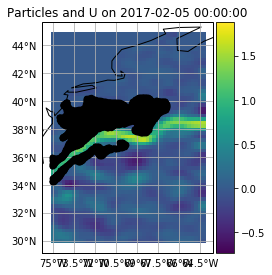

In [130]:
pset.show(field=fieldset.U)

In [134]:
plotTrajectoriesFile(savefilename);

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/bbarcelo/HOME_SCIENCE/Scripts/2019_SSS_Ladvection/simulation_notebooks/sim_Oleander_back_alt_20170212_07days.nc'